- https://huggingface.co/docs/diffusers/tutorials/basic_training 
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers_doc/en/pytorch/basic_training.ipynb#scrollTo=1nU73rLHujm7

# Train a diffusion model tutorial

In [1]:
# If you share your model with community, you can login from a notebook

from huggingface_hub import notebook_login
notebook_login()

# or login in from the terminal
# huggingface-cli login

In [2]:
# checkpoints are large, so you can use Git-LFS
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [25]:
from dataclasses import dataclass
from datasets import load_dataset
from torchvision import transforms
from diffusers import UNet2DModel
from PIL import Image
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup

from accelerate import Accelerator
from accelerate import notebook_launcher
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import math
import os
import glob


## Training configuration

In [46]:
# Training configuration
@dataclass
class TrainingConfig:
    image_size = 128
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision ="fp16" # 'no' for float32
    output_dir = "ddpm-butterflies-128"
    
    push_to_hub = True
    hub_private_repo = False
    overwrite_output_dir = True # re-running -> overwrite old model
    seed = 33
    
config = TrainingConfig()

## Load dataset

In [5]:
config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

Repo card metadata block was not found. Setting CardData to empty.


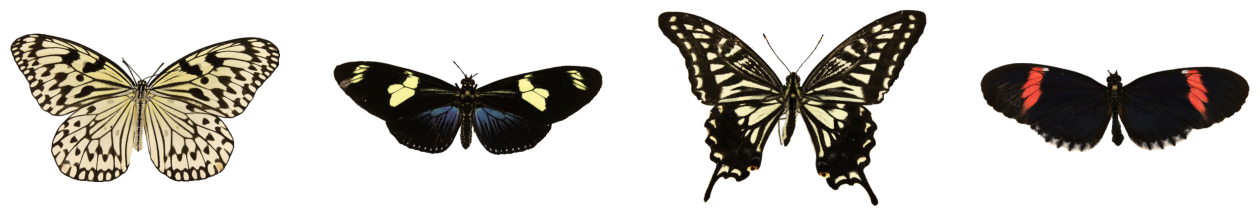

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(16,4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [7]:
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [8]:
def transforms(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images":images}

dataset.set_transform(transforms)

In [37]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size,shuffle=True)

## Create a UNet2Model

In [10]:
model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D", # ResNet downsampling
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D", # Resnet downsampling with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [11]:
# quickly check model output shape match sample image shape
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape :", sample_image.shape)
print("Output shape :", model(sample_image, timestep=0).sample.shape)

Input shape : torch.Size([1, 3, 128, 128])
Output shape : torch.Size([1, 3, 128, 128])


## Create a schedular 

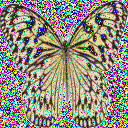

In [21]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0,2,3,1) + 1.0)*127.5).type(torch.uint8).numpy()[0])

In [13]:
noise_pred=model(noisy_image, timesteps).sample
lodd = F.mse_loss(noise_pred, noise)

## Train the model

In [47]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader)*config.num_epochs),
)

In [15]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i // cols*h))
        return grid
    
def evaluate(config, epoch, pipeline):
    # backward diffusion process : random noise -> sample image
    
    # default type : PIL.Image
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images
    
    image_grid = make_grid(images, rows=4, cols=4)
    
    # save images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.saveZ(f"{test_dir}/{epoch:04d}.png")

In [52]:
def get_full_repo_name(model_id: str, organization: str = None, token: str=None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"
    
def train_loop(config, model, noise_schedular, optimizer, train_dataloader, lr_scheduler):
    # initialize accerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.output_dir is None :
            os.makedirs(config.output_dir)
        
        # ※If do not make your own repository, a down case is not working    
        # if config.push_to_hub:
        #     repo_name=get_full_repo_name(Path(config.output_dir).name) 
        #     repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
        
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0
    
    # Now train the model!
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        
        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            
            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()
            
            # add noise to the clean images at each timestep
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss":loss.detach().item(), "lr":lr_scheduler.get_last_lr()[0], "step":global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step+=1
        
        # After each epoch - demo images with evaluate & save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_schedular)
            
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs -1 :
                evaluate(config, epoch, pipeline)
            
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)
                
                # ※ If do not make your own repository, a down case is not working
                # if config.push_to_hub:
                #     repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                # else:
                #     pipeline.save_pretrained(config.output_dir)

🚨 I don't make my repository, so "push_to-hub" does not working

In [53]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

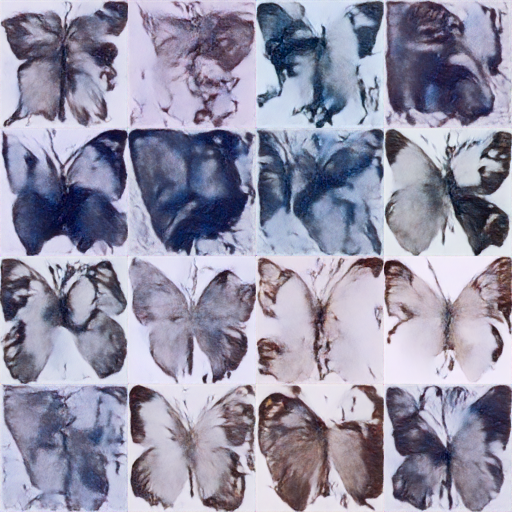

In [54]:
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[1])